In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import logging
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
# from efficientnet.keras import preprocess_input
from keras.models import load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Layer, ReLU, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, AveragePooling2D, ReLU, AlphaDropout, Conv2D, GlobalAveragePooling2D, Dense, Add, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3, VGG16, MobileNetV2, ResNet50V2
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from keras.utils import load_img, img_to_array

tf.get_logger().setLevel(logging.ERROR)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
ns = '2' # stage ke ns
name = f'TDCNN_{ns}'

labels = ['CLR', 'BSL', 'SM']

# Pre-processing of the images

In [4]:
#LOAD THE DATA

#Data split
train_path=f"/content/drive/MyDrive/Capstone Co-ffee/newdataset/swatdcnn/data/Augmented/stage_{ns}"
val_path=f"/content/drive/MyDrive/Capstone Co-ffee/newdataset/swatdcnn/data/Augmented/stage_{ns}/validation"
test_path=f"/content/drive/MyDrive/Capstone Co-ffee/newdataset/swatdcnn/test/stage-{ns}/test"

#Set image shapes
img_rows, img_cols = 224, 224
channel_depth = 3
input_shape = (img_rows,img_cols,channel_depth)
model_input = Input(shape=input_shape)


In [5]:
batch_size = 16

def ImgDataGen(file_path,f=False):    
    file_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    file_set = file_datagen.flow_from_directory(
        file_path,
        target_size = (img_rows,img_cols),
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = f,
    )
    return file_set

In [6]:
test_set = ImgDataGen(test_path)
num_classes= len(test_set.class_indices)

Found 311 images belonging to 3 classes.


# Load Model

In [7]:
model1 = f'/content/drive/MyDrive/Capstone Co-ffee/weights/stage{ns}/densenet121_{ns}.h5'
model2 = f'/content/drive/MyDrive/Capstone Co-ffee/weights/stage{ns}/InceptionV3_{ns}.h5'
model3 = f'/content/drive/MyDrive/Capstone Co-ffee/weights/stage{ns}/VGG16_{ns}.h5'

In [8]:
def densenet(model_input):
    densenet = DenseNet121(weights='imagenet', include_top=False, input_tensor=model_input)
    for layer in densenet.layers:layer.trainable = False
    # our layers - you can add more if you want
    y = GlobalAveragePooling2D()(densenet.output)
    y = Dense(512, activation='relu', use_bias=True)(y)
    y = Dropout(0.5)(y)
    prediction = Dense(num_classes,activation='softmax')(y)
    model = Model(inputs=densenet.input, outputs=prediction, name='DenseNet121')
    # tell the model what cost and optimization method to use
    model.load_weights(model1)
    return model

def Inception(model_input):
    InceptionV3_builder = InceptionV3(
        weights='imagenet', 
        include_top=False, 
        input_tensor = model_input
    )

    #FINE-TUNING
    for layer in InceptionV3_builder.layers:
        layer.trainable = False
    for BatchNormalization in InceptionV3_builder.layers:
        BatchNormalization.trainable = True
    x = InceptionV3_builder.layers[-1].output    
    x = GlobalAveragePooling2D(name='GAP-inceptionv3')(x)
    x = Dropout(0.5, name='Droput-inceptionv3')(x)
    predictions = Dense(num_classes, activation='softmax', name='Softmax-inceptionv3')(x)
    model = Model(inputs=InceptionV3_builder.input, outputs=predictions, name='Inceptionv3')
    model.load_weights(model2)
    return model

def vgg16(model_input):
    vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=model_input)
    for layer in vgg16.layers:layer.trainable = False
    # our layers - you can add more if you want
    y = GlobalAveragePooling2D()(vgg16.output)
    y = Dense(512, activation='relu', use_bias=True)(y)
    y = Dropout(0.5)(y)
    prediction = Dense(num_classes,activation='softmax')(y)
    model = Model(inputs=vgg16.input, outputs=prediction, name='VGG16')
    # tell the model what cost and optimization method to use
    model.load_weights(model3)
    return model

In [9]:
model1,model2,model3 = densenet(model_input),Inception(model_input),vgg16(model_input)

58900480/58889256 [==============================] - 1s 0us/step


# Fusion Model

In [10]:
models = [model1, model2, model3]

In [11]:
[m.layers[0] for m in models]

In [12]:
outputs = [m.output for m in models]
y = tf.keras.layers.Average()(outputs)
TDCNN = Model(model_input, y, name=name)

In [13]:
TDCNN.input, TDCNN.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'average')>)

In [14]:
file_model = f"weights/{name}.h5"
tf.keras.models.save_model(TDCNN,file_model)

# Testing

In [15]:
optimizer = Adam(learning_rate=0.0001)

TDCNN.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
) 

In [17]:
# evaluating test
TDCNN.evaluate(test_set,batch_size=32)
y_pred = TDCNN.predict(test_set)
y_pred = np.argmax(y_pred,axis=1)
accuracy_score(y_pred,test_set.classes)
print(classification_report(y_pred,test_set.classes))

20/20 [==============================] - 253s 12s/step - loss: 0.1824 - accuracy: 0.9486
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       133
           1       0.91      0.91      0.91        87
           2       1.00      1.00      1.00        91

    accuracy                           0.95       311
   macro avg       0.95      0.95      0.95       311
weighted avg       0.95      0.95      0.95       311



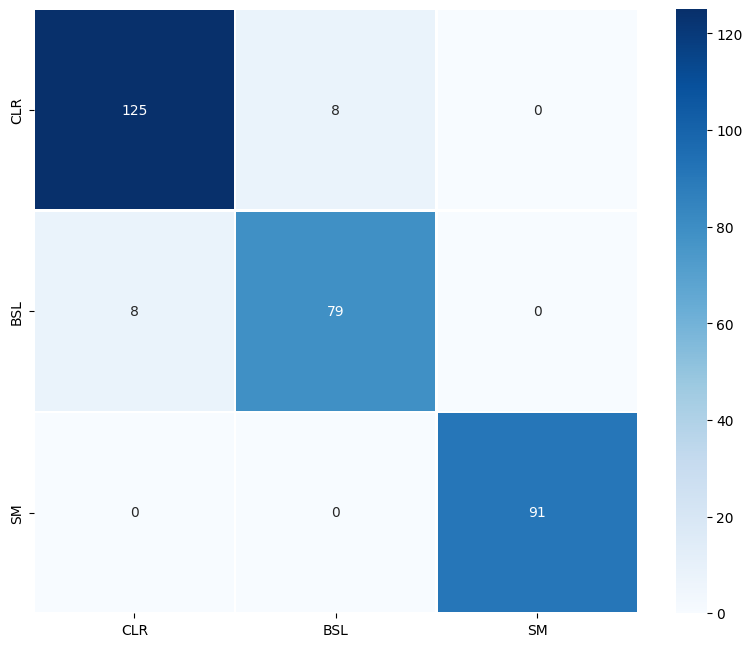

In [18]:
import seaborn as sns

# confusion_matrix
index = labels
columns = labels  

cm = confusion_matrix(y_pred, test_set.classes)
cm_df = pd.DataFrame(cm,columns,index)                      
fig = plt.figure(figsize=(10,8),dpi=100)  
fig = sns.heatmap(cm_df,cmap='Blues',annot=True, fmt="d",linewidths=1, square=True)


In [19]:
image_format = 'svg' # e.g .png, .svg, etc.
image_name = name+'.svg'

figure = fig.get_figure()  
figure.savefig(image_name, format=image_format, dpi=1200)